In [1]:
!pip install yfinance
!pip install morningstar-data

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',100)
import matplotlib.pyplot as plt

import scipy
import seaborn as sns
import statsmodels.api as sm
from IPython.display import display

import requests
#--
import cvxpy as cp
from pypfopt import expected_returns, risk_models, EfficientFrontier
# import mlfinlab
import QuantLib as ql
import yfinance as yf

#--
from api_functions import *


In [173]:
def plot_EfficientFrontier(mu, S):
    # Obtener puntos de la frontera eficiente
    efrontier_returns = np.linspace(0.01, 0.19, 100)
    efrontier_risks = []

    for r in efrontier_returns:
        ef_new = EfficientFrontier(mu, S) # inicializar - instancia Optimizador
        ef_new.efficient_return(r)
        efrontier_risks.append(ef_new.portfolio_performance()[1])

    # PLOT
    plt.figure(figsize=(10, 6))
    plt.plot(efrontier_risks, efrontier_returns, label="Frontera Eficiente")
    plt.title('Frontera Eficiente')
    plt.xlabel('Riesgo (Desviación Estándar)')
    plt.ylabel('Retorno Esperado')
    plt.scatter(performance[1], performance[0], color='red', marker='*', s=200, label="Portafolio Óptimo")
    plt.legend()

def plot_returns(returns=returns):
    plt.figure(figsize=(10, 6))
    sns.histplot(returns, kde=True, bins=30)
    plt.title('Distribución de Rendimientos Diarios')
    plt.show()


In [122]:
#< Initial display)>#
print(params)

{'access_key': '11eaea255a0fa4c2f436638015f87e9b', 'symbols': 'ASML,IDR.MC,PFE,TOELY,MRNA'}


{'access_key': '11eaea255a0fa4c2f436638015f87e9b', 'symbols': 'ASML,IDR.MC,PFE,TOELY,MRNA', 'date_from': '2020-01-01', 'date_to': '2025-02-27', 'limit': 10000}
<class 'pandas.core.frame.DataFrame'>
Index: 1291 entries, 2020-01-02 to 2025-02-26
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ASML    1291 non-null   float64
 1   MRNA    1291 non-null   float64
 2   PFE     1291 non-null   float64
 3   TOELY   1291 non-null   float64
dtypes: float64(4)
memory usage: 50.4+ KB


symbol,ASML,MRNA,PFE,TOELY
symbol,,,,
ASML,1.000000,0.367107,-0.229468,0.682632
MRNA,0.367107,1.000000,0.579060,0.584154
PFE,-0.229468,0.579060,1.000000,0.280576
TOELY,0.682632,0.584154,0.280576,1.000000


Retorno esperado:
 symbol
ASML     0.193856
MRNA     0.115050
PFE     -0.070200
TOELY    0.065826
dtype: float64

Matriz de covarianza:
 symbol      ASML      MRNA       PFE     TOELY
symbol                                        
ASML    0.187840  0.063874  0.022224  0.114645
MRNA    0.063874  0.568842  0.047094  0.048034
PFE     0.022224  0.047094  0.076685  0.013674
TOELY   0.114645  0.048034  0.013674  0.199557
Expected annual return: 18.7%
Annual volatility: 41.4%
Sharpe Ratio: 0.45

Pesos óptimos para cada activo:
OrderedDict([('ASML', 0.917714067724295), ('MRNA', 0.082285932275705), ('PFE', 0.0), ('TOELY', 0.0)])


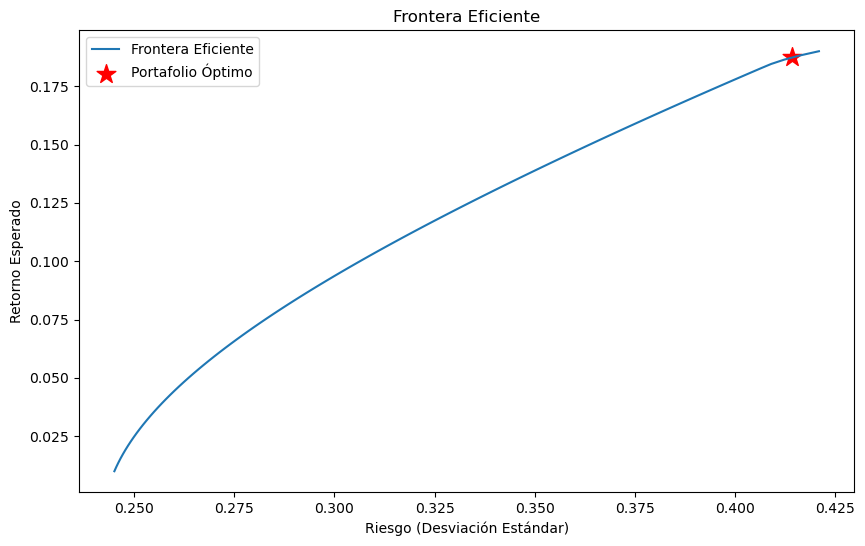

In [176]:
# -- MAIN -- #
params.update(
    {'date_from' : '2020-01-01', 'date_to' : pd.to_datetime('today').date().strftime('%Y-%m-%d'), 
     'limit':10000})
print(params)

histdata = get_Heod(params)

df = histdata.pivot(columns='symbol', values='adj_close').dropna() # df de Adj-Close
df.info()
display(df.corr()) # Matriz Correlación

returns = df.pct_change().dropna()




mu = expected_returns.mean_historical_return(df)  # Retorno esperado
S = risk_models.sample_cov(df)  # Matriz de covarianza

print("Retorno esperado:\n", mu)
print("\nMatriz de covarianza:\n", S)




ef = EfficientFrontier(mu, S)  # (I!) iniciar - optimizador de Portfolio

weights = ef.max_sharpe()  # maximizar - Sharpe (#criterion)

performance = ef.portfolio_performance(verbose=True) # rendimiento y riesgo - Portfolio óptimo

print("\nPesos óptimos para cada activo:")
print(weights)



plot_EfficientFrontier(mu, S)


In [18]:
#-----------------------------------------------#
